In [1]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import glob
import numpy as np
import pandas as pd
import cv2

C:\Users\woodw\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\woodw\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from keras.layers import Input, merge, Concatenate, Dense, Dropout, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, Softmax, LeakyReLU, Flatten, MaxPool2D, MaxPool3D, Embedding, GRU
from keras.layers.convolutional import Convolution2D, UpSampling2D, SeparableConv2D, UpSampling3D
from keras.layers import PReLU, LeakyReLU
from keras.models import Model
from keras.models import load_model
import keras.backend as K
from keras import layers
from keras import activations
from keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import sent_tokenize, word_tokenize 
import tensorflow as tf

Using TensorFlow backend.


In [3]:
img_paths = glob.glob('cleaned-data\*.jpg')

In [4]:
captions = pd.read_csv('./coco-captions-2017-clean.csv')

In [5]:
len(captions)

118287

In [6]:
annot_list = captions.values[:1600]
data = [] 
corpus_dict = {}
# iterate through each caption 
max_sequence_length = float("-inf")
for row in annot_list: 
    temp = [] 
      
    #tokenize the captions into words 
    for j in word_tokenize(row[2]): 
        temp.append(j.lower()) 
        corpus_dict[j.lower()] = 0
    if len(temp) > max_sequence_length:
        max_sequence_length = len(temp)
    data.append(temp) 

for index, word in enumerate(corpus_dict.keys()):
    corpus_dict[word] = index + 1
    
corpus_size = len(corpus_dict.keys())

In [8]:
max_sequence_length

27

In [9]:
w2v_model = Word2Vec.load('./text_encoding.bin')

In [10]:
len(w2v_model.wv.vocab)

13896

In [11]:
captions_X = []
caption_strings = []

for row in annot_list:
    caption_conv = []
    for word in word_tokenize(row[2].lower()):
        caption_conv.append(w2v_model[word])
    captions_X.append(np.array(caption_conv))
    caption_strings.append(row[2].lower())
    
    
    

C:\Users\woodw\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [12]:
len(w2v_model.wv.vocab)

13896

In [12]:
# Pad with 0-vectors
for i in range(len(captions_X)):
    captions_X[i].resize((27, 100))


In [13]:
captions_X = np.array(captions_X)

In [14]:
len(captions_X)

1600

In [15]:
def data_loader(file_path):
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(cv2.imread(img_path) / 255.0)
    return np.array(data)

In [16]:
imgs_all = data_loader('./cleaned-data/')
imgs_y = imgs_all[:1600]

In [32]:
# autoencoder = load_model('./autoencoder-v2-models/autoencoder-v2-9k-epochs.h5')
import keras.metrics
def image_closeness(y_pred, y_true):
    return K.mean(1 - K.abs(y_pred - y_true), axis=-1)
keras.metrics.image_closeness = image_closeness

# autoencoder = load_model('./autoencoder-v3-models/autoencoder-v3-2k-epochs.h5')
autoencoder = load_model('./autoencoder-v2-models/autoencoder-v2-9k-epochs.h5') # transpose conv

In [33]:
decoder = autoencoder.layers[2]

In [34]:
for layer in decoder.layers:
    layer.trainable = False
decoder.trainable = False

In [28]:
def build_intermediate_model(input_shape, name='textencoder', encode_channels=[4, 8, 16, 32, 32]):
    embedding_size = 64
    gru_size = 1024
    input_length = 27
    input_layer = Input(shape=input_shape)
#     encoder_block = Embedding(434, 64, input_length=27)(input_layer)
    
    
    embedded_seq, state_i = GRU(gru_size, return_state=True, name='gru')(input_layer)
    state_i = Dense(1024)(state_i)
    state_i = LeakyReLU()(state_i)

    
        
 
    encoder_block = Reshape((32, 32, 1))(state_i)
    
    for index, channel in enumerate(encode_channels):
        
        shortcut = Conv2D(channel, 3, padding='same', trainable=False)(encoder_block)
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)    
        
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        
        
        encoder_block = Add()([encoder_block, shortcut])
        
        #encoder_block = MaxPool2D()(encoder_block) # losses information density
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)

    output_layer = encoder_block
    return Model(input_layer, output_layer, name=name)

In [67]:
model_intermediate = build_intermediate_model((27, 100))

In [68]:
model_intermediate.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 27, 100)      0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 100), (None, 60300       input_8[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 1024)         103424      gru[0][1]                        
__________________________________________________________________________________________________
leaky_re_lu_97 (LeakyReLU)      (None, 1024)         0           dense_7[0][0]                    
__________________________________________________________________________________________________
reshape_7 

In [69]:
len(model_intermediate.layers)

55

In [30]:
def build_combined_model():
    input_caption = Input(shape=(27, 100))
    latent_representation = model_intermediate(input_caption)
    decoded_img = decoder(latent_representation)
    autoencoder = Model(input_caption, decoded_img, name="text2img")
    return autoencoder

In [71]:
model_text2img = build_combined_model()

In [72]:
model_text2img.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 27, 100)           0         
_________________________________________________________________
textencoder (Model)          (None, 32, 32, 32)        238216    
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       51763     
Total params: 289,979
Trainable params: 222,518
Non-trainable params: 67,461
_________________________________________________________________


In [17]:
def image_closeness(y_true, y_pred):
#     return K.mean(K.equal(y_true, y_pred), axis=-1)
    return K.mean(1 - K.abs(y_true - y_pred), axis=-1)
import keras
keras.metrics.image_closeness = image_closeness

In [74]:
model_text2img.compile(optimizer='adam', loss='mse', metrics=[image_closeness, 'accuracy'])

In [19]:
m = load_model('./text2img-models-v3/text2img-3k-epochs.h5')

In [20]:
history = m.fit(captions_X, imgs_y, epochs=1, batch_size=32, shuffle=True)
# plot_history(history)

Epoch 1/1
1600/1600 [==============================] - 6s 4ms/step - loss: 0.0096 - image_closeness: 0.9339 - acc: 0.7321


In [75]:
for i in range (1, 3):
    history = model_text2img.fit(captions_X, imgs_y, epochs=1000, batch_size=32, shuffle=True)
    print(str(i) + 'k epochs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    model_text2img.save('.\\text2img-models-v5\\text2img-' + str(i) + 'k-epochs.h5')
    plot_history(history)
#     show_converted(4)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

Epoch 1/1000
1600/1600 [==============================] - 14s 9ms/step - loss: 0.0913 - image_closeness: 0.7509 - acc: 0.3890
Epoch 2/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0787 - image_closeness: 0.7636 - acc: 0.4062
Epoch 3/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0769 - image_closeness: 0.7656 - acc: 0.4199
Epoch 4/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0753 - image_closeness: 0.7684 - acc: 0.4614
Epoch 5/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0762 - image_closeness: 0.7674 - acc: 0.4517
Epoch 6/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0743 - image_closeness: 0.7705 - acc: 0.4737
Epoch 7/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0747 - image_closeness: 0.7706 - acc: 0.4699
Epoch 8/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0738 - image_closeness: 0.7716 - acc: 0.4687

1600/1600 [==============================] - 4s 2ms/step - loss: 0.0545 - image_closeness: 0.8110 - acc: 0.4864
Epoch 67/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0545 - image_closeness: 0.8112 - acc: 0.4899
Epoch 68/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0546 - image_closeness: 0.8108 - acc: 0.4807
Epoch 69/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0540 - image_closeness: 0.8120 - acc: 0.4830
Epoch 70/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0541 - image_closeness: 0.8118 - acc: 0.4902
Epoch 71/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0538 - image_closeness: 0.8124 - acc: 0.4892
Epoch 72/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0534 - image_closeness: 0.8133 - acc: 0.4928
Epoch 73/1000
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0534 - image_closeness: 0.8133 - acc: 0.4883
Epoch 

KeyboardInterrupt: 

In [80]:
# model_text2img = load_model('./text2img-models-v2/text2img-1k-epochs.h5')
model_text2img.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 27, 100)           0         
_________________________________________________________________
textencoder (Model)          (None, 32, 32, 32)        4542844   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       51763     
Total params: 4,594,607
Trainable params: 4,536,522
Non-trainable params: 58,085
_________________________________________________________________


In [139]:
model_text2img_t = load_model('./text2img-models-v4/text2img-2k-epochs.h5')
model_text2img_u = load_model('./text2img-models-v3/text2img-3k-epochs.h5')

In [282]:
for caption in caption_strings:
    if 'woman on a surfboard' in caption:
        print(caption)

C:\Users\woodw\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


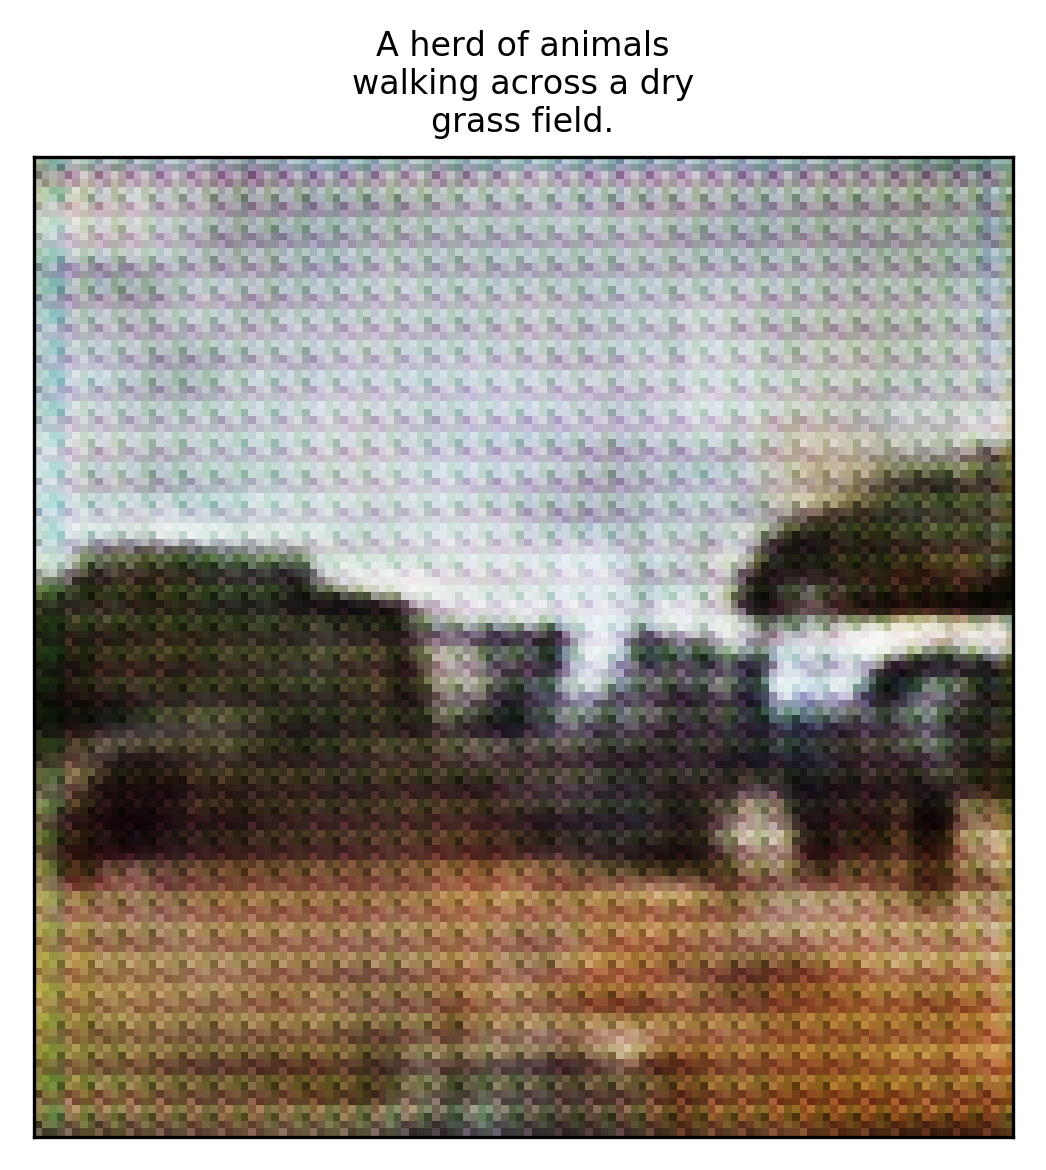

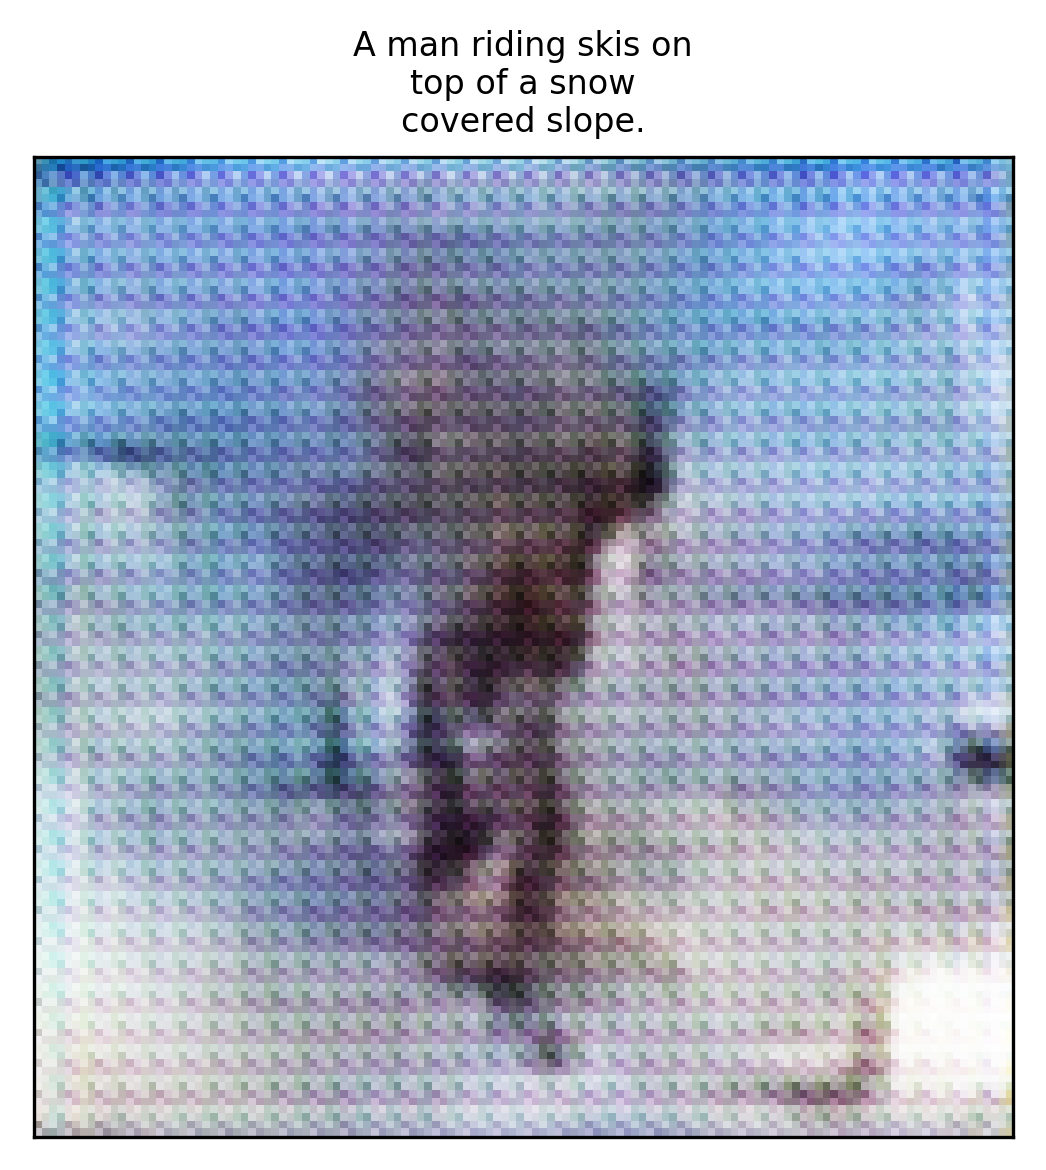

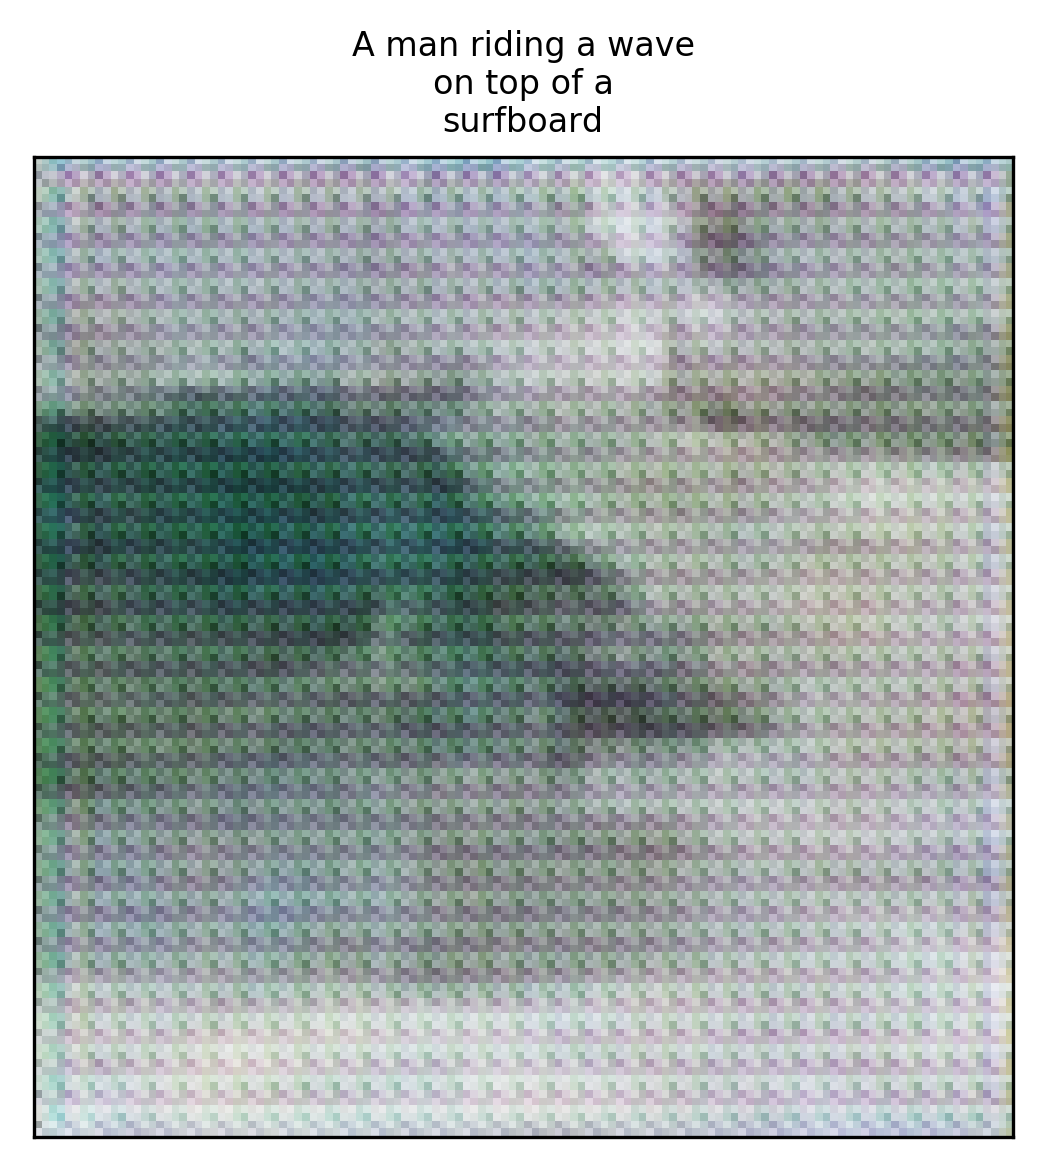

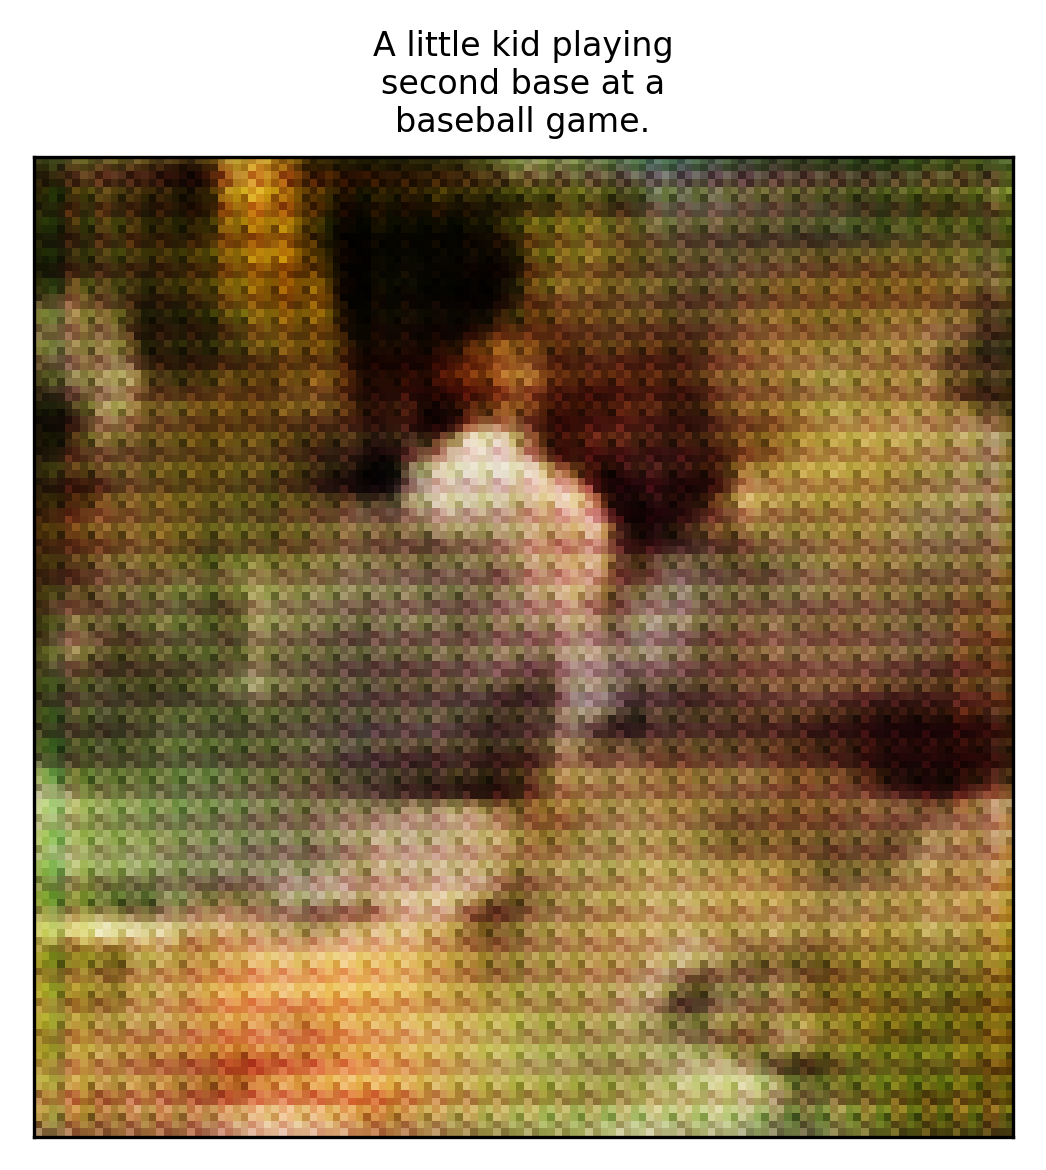

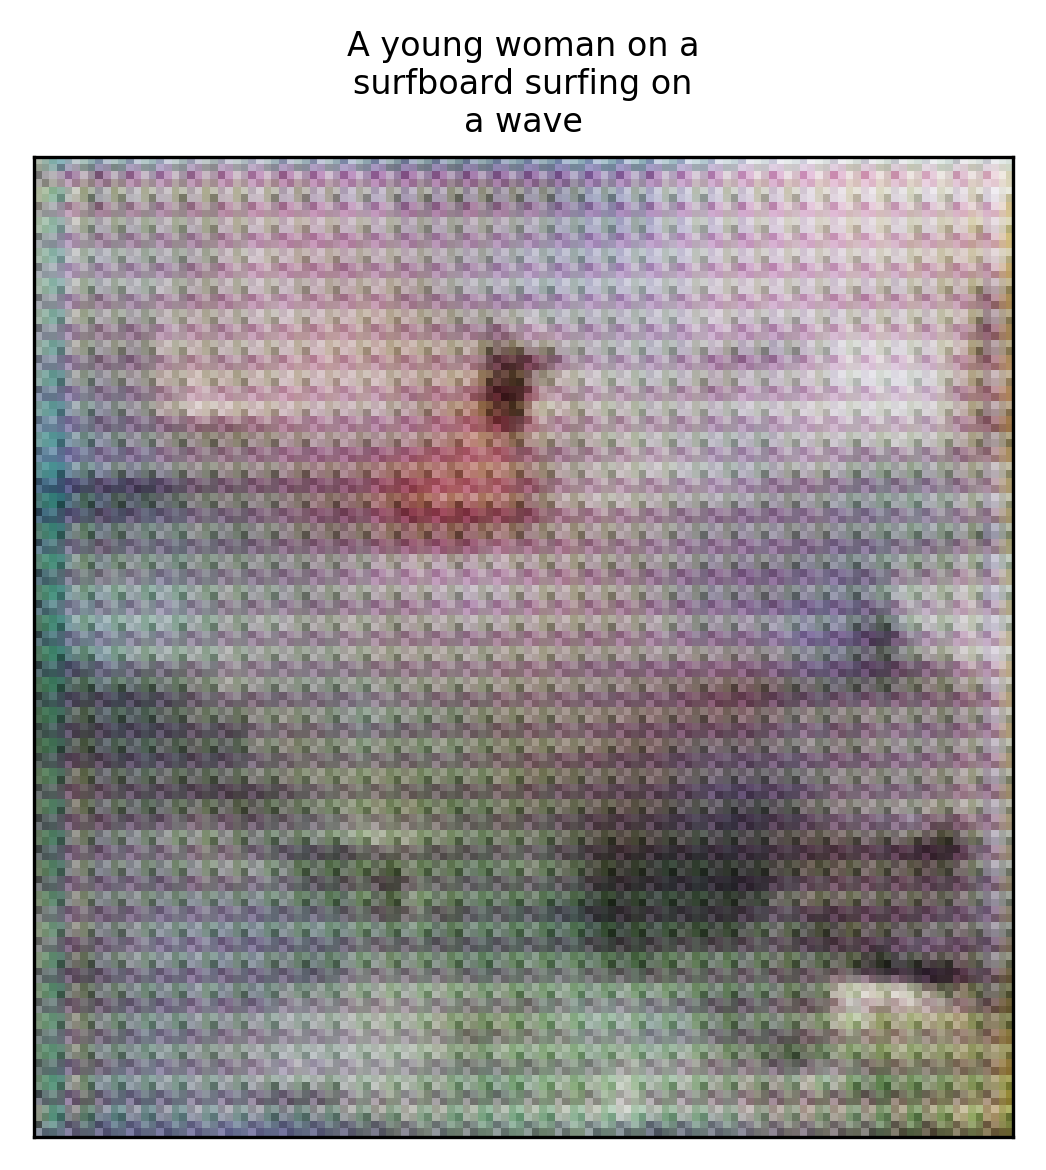

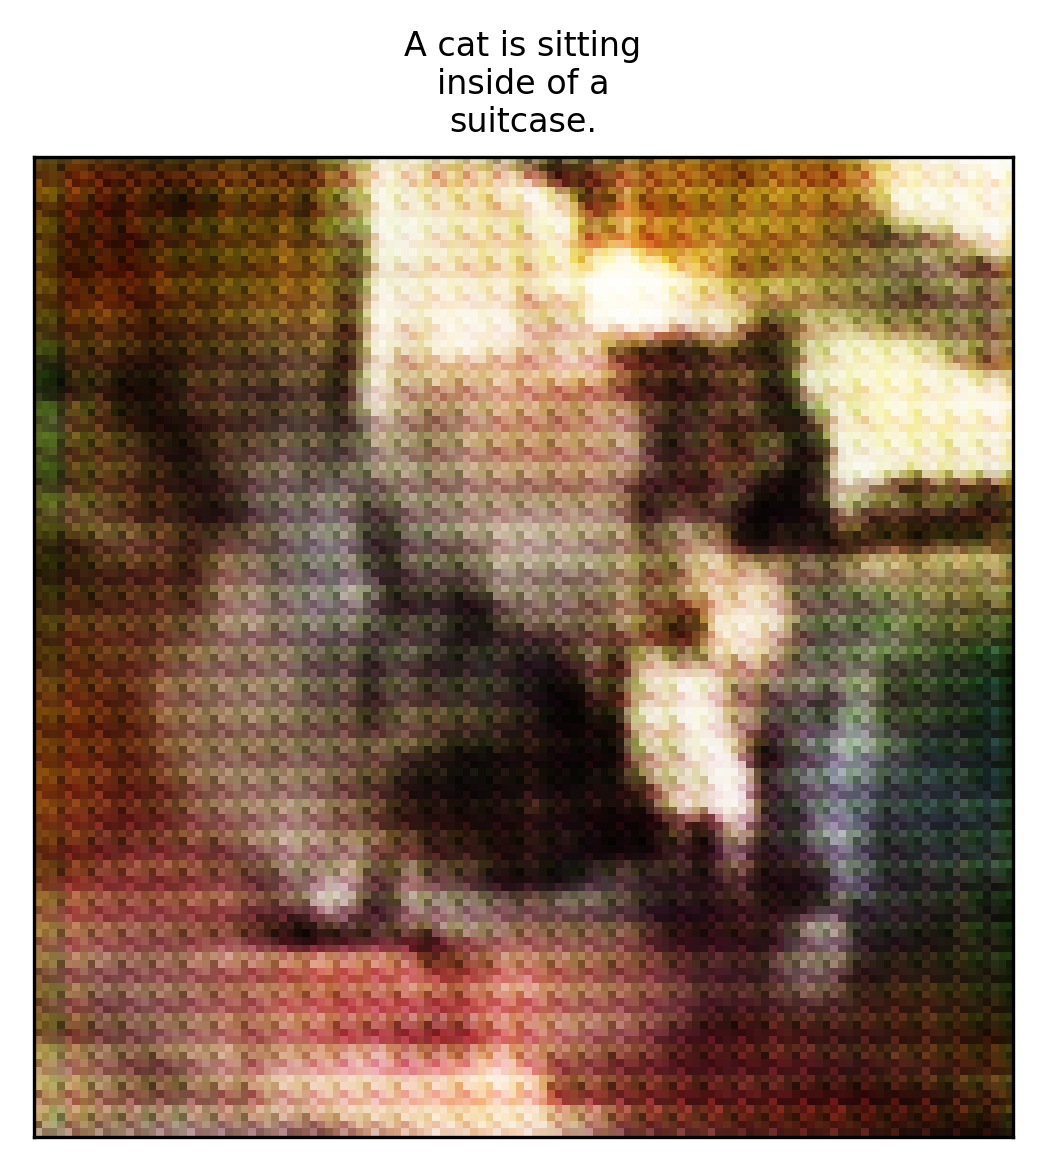

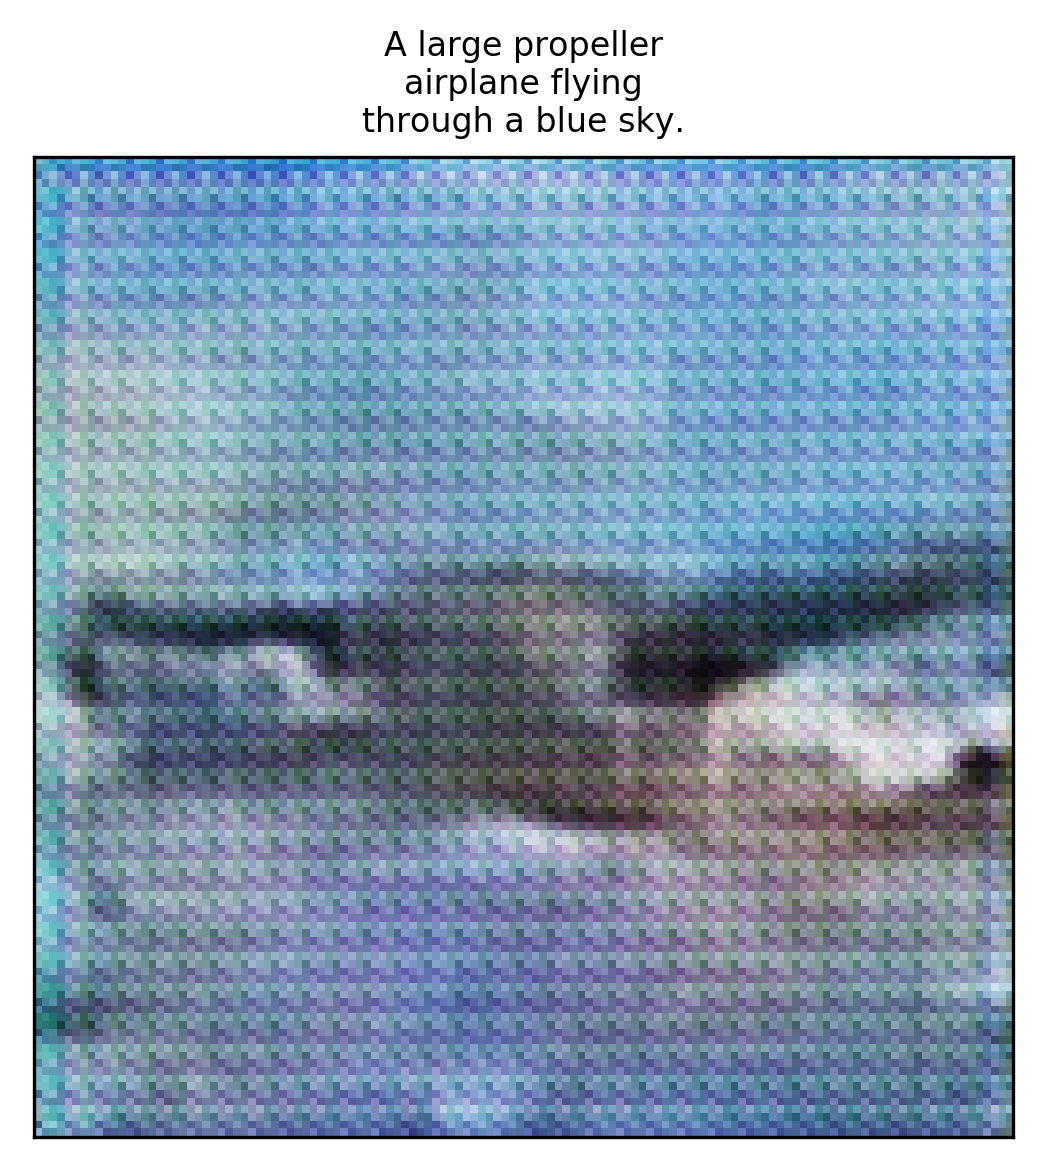

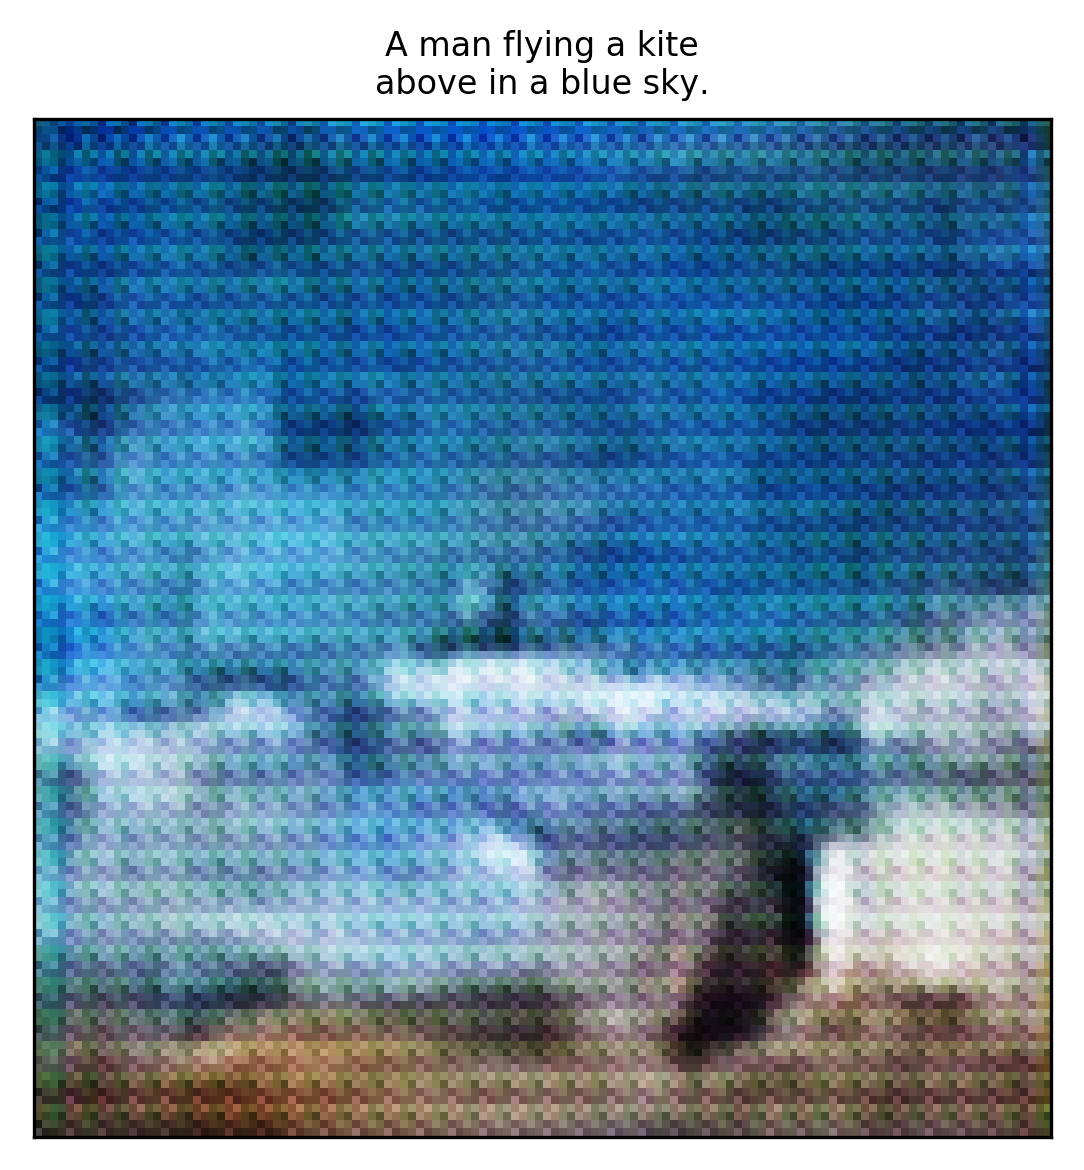

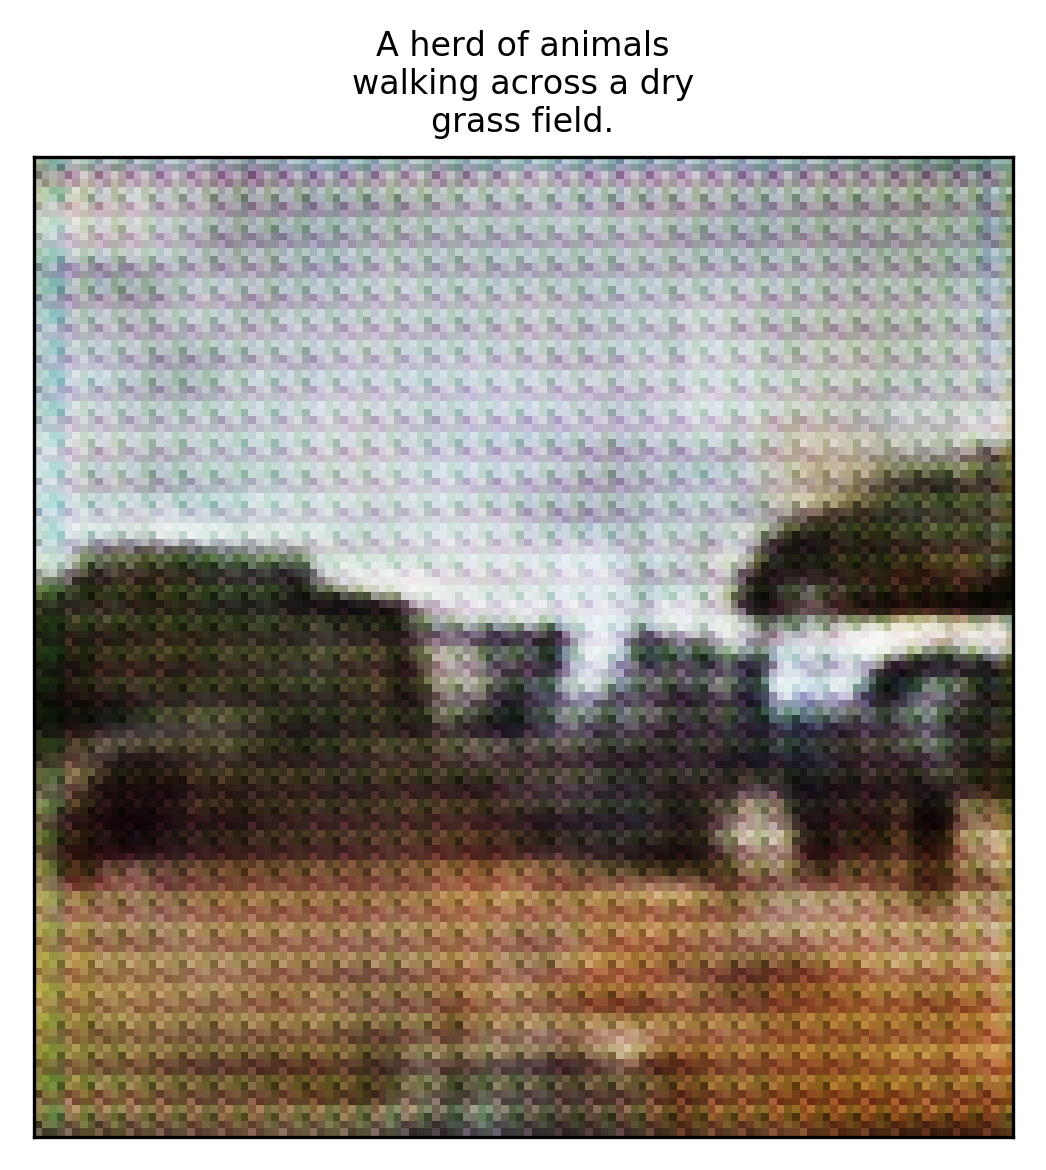

In [161]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import textwrap
# figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
def rgb_imshow(img, name):
#     figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
    plt.xticks([])
    plt.yticks([])
    if name is not None:
        plt.title('\n'.join(textwrap.wrap(name, 20)), fontsize=8)
    else:
        plt.title(name)
    plt.imshow(cv2.cvtColor((img).astype(np.float32), cv2.COLOR_BGR2RGB))
#     plt.show()

def show_converted(model, caption):
    
    

#     caption_input = testcaptions[0] 
# THE VAULT
# 1604, 1610, 1628, 1642, 1748, 1771, 1772, 1860, 1926, 13018, 13145, 13189, 13435, 13517
#     vault = [0, 4, 5, 69]
    figure(num=None, dpi=300, facecolor='w', edgecolor='k')

    caption_input = caption_encoding(caption)
    target_image = testimgs[0]
    decoded_img = model.predict(np.array([caption_input]), steps=None)[0]
    rgb_imshow(decoded_img, caption)
    

    



    plt.tight_layout()
#     plt.savefig(f'./testing-final-images/{caption}.png', bbox_inches='tight')
    plt.show()


# show_converted(2)
# show_converted(4)
# show_converted(18)
# show_converted(65)
# for i in range(65, 70):

# [68, 124, 47, 38]
testimgs = [imgs_y[68], imgs_y[124], imgs_y[47], imgs_y[38]]
testcaptions = [captions_X[68], captions_X[124], captions_X[47], captions_X[38]]
teststrings = [caption_strings[68], caption_strings[124], caption_strings[47], caption_strings[38]]

caps = \
[
    'A herd of animals walking across a dry grass field.',\
    'A man riding skis on top of a snow covered slope.',\
    'A man riding a wave on top of a surfboard',\
    'A little kid playing second base at a baseball game.',\
    'A young woman on a surfboard surfing on a wave',\
    'A cat is sitting inside of a suitcase.',\
    'A large propeller airplane flying through a blue sky.',\
    'A man flying a kite above in a blue sky.',\
    'A herd of animals walking across a dry grass field.',\
]

for cap in caps:
    show_converted(model_text2img_t, cap)
# show_converted(3, model_text2img_u, caption=caption_encoding(caption_strings[img_num]))




# decoded_img1 = model_text2img.predict(np.array([captions_X[4]]))[0]
# decoded_img2 = model_text2img.predict(np.array([captions_X[5]]))[0]

# flat_img = np.array(decoded_img2 - decoded_img1)
# flat_img = flat_img.flatten()
# nonzero_elems = [x for x in flat_img if x != 0]
# print (len(decoded_img1.flatten()))
# print (len(nonzero_elems))
# print (np.max(flat_img))


In [19]:
def caption_encoding(string):
    caption_conv = []
    for word in word_tokenize(string.lower()):
        caption_conv.append(w2v_model[word])
    caption_conv = np.array(caption_conv)
    caption_conv.resize((27, 100))
    return caption_conv

In [20]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.title("Accuracy")
    plt.show()
    plt.plot(history.history['loss'])
    plt.title("Loss")
    plt.show()

In [ ]:
np.shape(model_text2img.predict(np.array([captions_X[0]]))[0])

In [21]:
def pad_text(text):
    paddings = tf.constant([[0, 0], [0, 52]])
    text = tf.pad(text, paddings, 'CONSTANT')
    return text

def build_discriminator(encode_channels=[8, 16, 32]):
    #text_input = Input(shape=(27, 100))
    image_input = Input(shape=(128, 128, 3))
    
    #text_attn = Flatten()(text_input)
    #resized_text = Lambda(pad_text)(resized_text)
    
    #concatentated_values = Concatenate(axis=3)([resized_text, image_input])
    
    for index, channel in enumerate(encode_channels):
        
#         shortcut = Conv2D(channel, 3, padding='same', trainable=False)(image_input if index == 0 else encoder_block)
        encoder_block = BatchNormalization()(image_input if index == 0 else encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        #encoder_block = Dropout(0.2)(encoder_block)
        
        encoder_block = BatchNormalization()(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        encoder_block = Conv2D(channel, 3, padding='same')(encoder_block)
        #encoder_block = Dropout(0.2)(encoder_block)
        
#         encoder_block = Add()([encoder_block, shortcut])
        
        encoder_block = Conv2D(channel, 3, padding='same', strides=2)(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)
        #encoder_block = Dropout(0.2)(encoder_block)
        
    
    encoder_block = Flatten()(encoder_block)
    #concatted = Concatenate()([encoder_block, text_attn])
    
    dense = Dense(1, activation='sigmoid')(encoder_block) #change to concatted if add text back
    
    return Model(image_input, dense, name='Discriminator') #Model([text_input, image_input], dense, name='Discriminator')
discriminator = build_discriminator()
discriminator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 8)       0         
_________________________________________________________________
conv

In [25]:
def build_gan():
    input_caption = Input(shape=(27, 100))
    input_image = Input(shape=(128, 128, 3))
    generated_image = model_text2img(input_caption)
    discriminator_output = discriminator(generated_image) #discriminator([input_caption, generated_image])
    

    gan = Model(input_caption, [discriminator_output, generated_image])
    return gan

gan = build_gan()
# discriminator.trainable = False
# g_adam = keras.optimizers.adam(lr=0.00005, beta_1=0.0, beta_2=0.999)
# adversarial_net = build_gan()
# adversarial_net.compile(optimizer=g_adam, loss=['binary_crossentropy', 'mse'], loss_weights=[1, 100], metrics=['binary_accuracy'])
# adversarial_net.summary()



In [35]:
model_intermediate = build_intermediate_model((27, 100))
model_text2img = build_combined_model()
discriminator = build_discriminator()
d_adam = keras.optimizers.adam(lr=0.00001, beta_1=0.0, beta_2=0.999)
discriminator.compile(optimizer=d_adam, loss='binary_crossentropy', metrics=['binary_accuracy'])
discriminator.trainable = False
adversarial_net = build_gan()
g_adam = keras.optimizers.adam(lr=0.0001, beta_1=0.0, beta_2=0.999)
adversarial_net.compile(optimizer=g_adam, loss=['binary_crossentropy', 'mse'], loss_weights=[1, 10], metrics=['binary_accuracy'])

In [36]:
captions_X = captions_X[:128]
imgs_y = imgs_y[:128]
caption_strings = caption_strings[:128]

In [138]:
from keras.utils.generic_utils import Progbar
from time import time

d_loss_means = []
d_acc_means = []
a_loss_means = []
t_loss_means = []

BATCHSIZE = 32
EPOCHS = 1000
for epoch in range(EPOCHS):
    num_data_pts = len(captions_X)
    np.random.seed(epoch)
    np.random.shuffle(captions_X)
    np.random.seed(epoch)
    np.random.shuffle(imgs_y)
    np.random.seed(epoch)
    np.random.shuffle(caption_strings)

    d_hist_loss = []
    d_hist_acc = []
    a_hist_loss = []
    t_hist_loss = []
    print()
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(num_data_pts // BATCHSIZE)
    #print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
    progress_bar = Progbar(target=int(num_data_pts // (BATCHSIZE)))
    minibatches_size = BATCHSIZE
    start_time = time()
    
    for index in range(int(num_data_pts // (BATCHSIZE))):
        progress_bar.update(index)
        
        #print(f'{BATCHSIZE*index}:{(BATCHSIZE*(index+1))}')
        images_real = imgs_y[BATCHSIZE*index:(BATCHSIZE*(index+1))]
        captions_batch = captions_X[BATCHSIZE*index:(BATCHSIZE*(index+1))]
        #print(edges_batch.shape)
        labels_fake = np.zeros([BATCHSIZE,1], dtype=np.float32)
        labels_real = np.ones([BATCHSIZE,1], dtype=np.float32)
        
        images_fake = model_text2img.predict(captions_batch)
        train_imgs = np.concatenate((images_real, images_fake))
        train_captions = np.concatenate((captions_batch, captions_batch))
        train_labels = np.concatenate((labels_real, labels_fake))
        
#         np.random.seed(index)
#         np.random.shuffle(train_imgs)
#         np.random.seed(index)
#         np.random.shuffle(train_captions)
#         np.random.seed(index)
#         np.random.shuffle(train_labels)
        
#         d_loss, d_acc = discriminator.train_on_batch([train_captions,train_imgs], train_labels)
 
        np.random.seed(index)
        np.random.shuffle(train_imgs)
        np.random.seed(index)
        np.random.shuffle(train_captions)
        np.random.seed(index)
        np.random.shuffle(train_labels)
        if index % 4 == 0:
            d_loss, d_acc = discriminator.train_on_batch(train_imgs, train_labels)
            d_hist_loss.append(d_loss)
            d_hist_acc.append(d_acc)
        #_loss = discriminator.train_on_batch([train_captions,train_imgs], train_labels)
        #d_loss_r = discriminator.train_on_batch([captions_batch,images_real], labels_real)
        
        
        a_loss_1, _, t_loss, _, t_acc = adversarial_net.train_on_batch(captions_batch, [labels_real, images_real])
        a_hist_loss.append(a_loss_1)
        t_hist_loss.append(t_loss)
        
        #discriminator.trainable = True
    
    t_loss_means.append(np.mean(t_hist_loss))
    d_loss_means.append(np.mean(d_hist_loss))
    a_loss_means.append(np.mean(a_hist_loss))
    d_acc_means.append(np.mean(d_hist_acc))
    print(np.mean(d_hist_acc))
    #gen_imgs = model_text2img_t.predict(captions_batch)

plt.title('Discriminator Loss')
plt.plot(d_loss_means)
plt.show()
plt.title('Discriminator Accuracy')
plt.plot(d_acc_means)
plt.show()
plt.title('Adversarial Loss')
plt.plot(a_loss_means)
plt.show()
plt.title('Text To Image Loss')
plt.plot(t_loss_means)
plt.show()
# adversarial_net.save_weights('.\\gan-v1\\gan-2k-epochs-weights.h5')
# model_text2img.save_weights('.\\gan-v1\\text2img-2k-epochs-weights.h5')


epoch 1 of 1000
3/4 [=====================>........] - ETA: 2stacc 0.35669327
1.0

epoch 2 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.3291607
0.84375

epoch 3 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.3667698
0.96875

epoch 4 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.41786957
0.9375

epoch 5 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.3961811
0.953125

epoch 6 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.36848068
0.984375

epoch 7 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.3907547
0.9375

epoch 8 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.4293766
0.984375

epoch 9 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.39762878
0.96875

epoch 10 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.44046593
0.984375

epoch 11 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.3805046
0.984375

epoch 12 of 1000
3/4 [=====================>...

3/4 [=====================>........] - ETA: 0stacc 0.42210007
1.0

epoch 32 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.41149902
1.0

epoch 33 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.4464302
1.0

epoch 34 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.39038277
1.0

epoch 35 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.44952393
1.0

epoch 36 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.50899696
1.0

epoch 37 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.46676064
1.0

epoch 38 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.46450043
1.0

epoch 39 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.4730339
1.0

epoch 40 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.46115112
1.0

epoch 41 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.4667511
1.0

epoch 42 of 1000
3/4 [=====================>........] - ETA: 0stacc 0.53103065
1.0

epoch 43 of 

KeyboardInterrupt: 

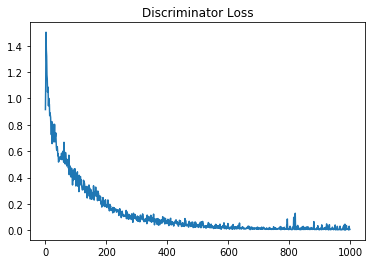

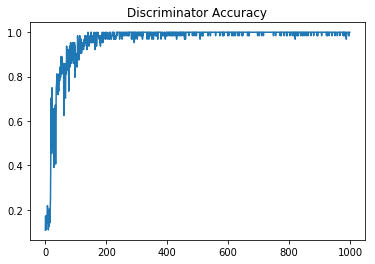

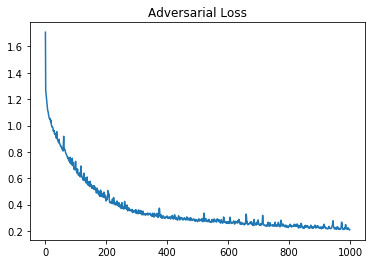

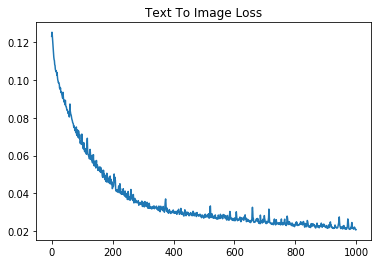

In [52]:
plt.title('Discriminator Loss')
plt.plot(d_loss_means)
# plt.savefig('./gan-v1/discriminator_loss-2k')
plt.show()
plt.title('Discriminator Accuracy')
plt.plot(d_acc_means)
# plt.savefig('./gan-v1/discriminator_acc-2k')
plt.show()
plt.title('Adversarial Loss')
plt.plot(a_loss_means)
# plt.savefig('./gan-v1/adversarial_loss-2k')
plt.show()
plt.title('Text To Image Loss')
plt.plot(t_loss_means)
# plt.savefig('./gan-v1/text2img_loss-2k')
plt.show()

68


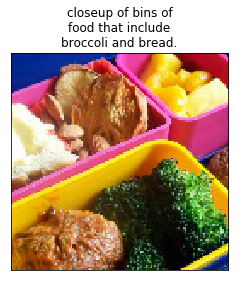

TypeError: show_converted() takes 1 positional argument but 2 were given

In [96]:


vault = [68, 124, 47, 38]
for img_num in vault:
    print(img_num)
    rgb_imshow(imgs_y[img_num], caption_strings[img_num]) 
    plt.show()
    show_converted(img_num, model_text2img)


In [80]:

model_intermediate = build_intermediate_model((27, 100))
model_text2img = build_combined_model()
#model_text2img.compile(optimizer='adam', loss='mse', metrics=[image_closeness, 'accuracy'])
discriminator = build_discriminator()

discriminator.compile(optimizer=d_adam, loss='binary_crossentropy', metrics=['binary_accuracy'])

discriminator.trainable = False
adversarial_net = build_gan()
adversarial_net.compile(optimizer=g_adam, loss=['binary_crossentropy', 'mse'], loss_weights=[1, 10], metrics=['binary_accuracy'])






In [142]:
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [117]:
for i in range(25):
    discriminator.trainable = False
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    discriminator.trainable = True
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
